In [161]:
import json
import os
import numpy as np
import pandas as pd
import emoji
from enchant.checker import SpellChecker

dirs = ["sejal", "camille", "erika"]

def text_has_emoji(text):
    num_emojis = 0
    for character in text:
        if character in emoji.UNICODE_EMOJI:
            num_emojis += 1
    return num_emojis

max_error_count = 3
min_text_length = 3

def is_in_english(quote):
    quote = quote.lower()
    quote = ' '.join([word for word in quote.split() if word[0] != "#" and word[0] != "@"])
    if len(quote.split()) <= 1:
        return True
    d = SpellChecker("en_US")
    d.set_text(quote)
    errors = [err.word for err in d]
    if len(quote.split()) <= 5 and len(errors) > max_error_count:
        return False
    elif len(quote.split()) > 5 and len(errors) >= 0.8*len(quote.split()):
        return False
    else:
        return True

identifier, photos, captions = [], [], []
collections, no_image, no_caption, too_few, non_english = 0, 0, 0, 0, 0
scraper_failed = 0
posts_per_user = []
mentions, hashtags, emojis, has_quotes, vanilla = 0, 0, 0, 0, 0
running_total = 0
finsta, finsta_users = 0, 0
root_count = [0, 0, 0]
root_user_count = [0, 0, 0]
valid_post_count = [0, 0, 0]
non_english_captions = []
total_h, total_m, total_e = 0, 0, 0
for i, root in enumerate(dirs):
    for fn in os.listdir("profiles/profiles_" + root + "/"):
        if fn.endswith(".json"):
            f = open("profiles/profiles_" + root + "/" + fn)
            root_user_count[i] += 1
            num_valid_entries = 0
            num_invalid_entries = 0
            user_identifiers, user_photos, user_captions = [], [], []
            h, m, q, e, v = 0, 0, 0, 0, 0
            data = json.load(f)
            posts = data["posts"]
            root_count[i] += len(posts)
            if data["followers"]["count"] >= 200:
                for p in posts:
                    if len(p["imgs"]) > 1:
                        collections += 1
                        num_invalid_entries += 1
                    elif len(p["imgs"]) == 0:
                        no_image += 1
                        num_invalid_entries += 1
                    elif p["caption"] == "":
                        no_caption += 1
                        num_invalid_entries += 1
                    elif is_in_english(p["caption"]) == False:
                        non_english_captions.append(p["caption"])
                        non_english += 1
                        num_invalid_entries += 1
                    else:
                        num_valid_entries += 1
                        vanilla_flag = True
                        user_identifiers.append(data["username"])
                        user_photos.append(p["imgs"][0])
                        if '"' in p["caption"]:
                            q += 1
                            vanilla_flag = False
                        if '@' in p["caption"]:
                            m += 1
                            vanilla_flag = False
                        if '#' in p["caption"]:
                            h += 1
                            vanilla_flag = False
                        for char in p["caption"]:
                            if char == "@":
                                total_m += 1
                            if char == "#":
                                total_h += 1
                        emojis_in_caption = text_has_emoji(p["caption"])
                        if emojis_in_caption != 0:
                            e += 1
                            total_e += emojis_in_caption
                            vanilla_flag = False
                        if vanilla_flag:
                            v += 1
                        user_captions.append(p["caption"].replace('"', '\''))
                if num_valid_entries >= 10:
                    running_total += num_valid_entries
                    valid_post_count[i] += num_valid_entries
                    hashtags += h
                    has_quotes += q
                    mentions += m
                    emojis += e
                    vanilla += v
                    identifier.append(user_identifiers)
                    photos.append(user_photos)
                    captions.append(user_captions)
                else:
                    too_few += num_valid_entries
                posts_per_user.append(num_valid_entries)
                if data["num_of_posts"] < 100:
                    scraper_failed += data["num_of_posts"] - num_valid_entries - num_invalid_entries
                else:
                    scraper_failed += 100 - num_valid_entries - num_invalid_entries
            else:
                finsta += len(data["posts"])
                finsta_users += 1
                posts_per_user.append(len(data["posts"]))
            f.close()
        
print(total_h, total_m, total_e)
left_space = 20
num_space = 8
# too_few = sum([p if (p < 10 and p > 0) else 0 for p in posts_per_user])
throwing_out = collections + no_image + no_caption + too_few + finsta + non_english
total = running_total + throwing_out
total_users = len(posts_per_user)
print("classification".ljust(left_space), "# posts".rjust(num_space), "pct %".rjust(num_space), "# users".rjust(num_space), "pct %".rjust(num_space))
print("––––––––––––––––––".ljust(left_space), "––––––".rjust(num_space), "––––––".rjust(num_space), "––––––".rjust(num_space), "––––––".rjust(num_space))
print("scraper failed".ljust(left_space), str(scraper_failed).rjust(num_space), str(round(scraper_failed * 100/ (total + scraper_failed), 2)).rjust(num_space))
print("TOTAL SCRAPED".ljust(left_space), ("("+str(total)+")").rjust(num_space), str(round(100, 2)).rjust(num_space), ("("+str(total_users)+")").rjust(num_space), str(round(100, 2)).rjust(num_space))
posts_per_user2 = [p for p in posts_per_user if p >= 10]
for i in range(len(root_count)):
    print(dirs[i].ljust(left_space), str(root_count[i]).rjust(num_space), str(round(root_count[i] * 100 / total, 2)).rjust(num_space), 
          str(root_user_count[i]).rjust(num_space), str(round(root_user_count[i] * 100 / total_users, 2)).rjust(num_space))
# print("mean ppu [before]".ljust(left_space), str(round(np.mean(posts_per_user), 2)).rjust(num_space))
# print("median ppu [before]".ljust(left_space), str(np.median(posts_per_user)).rjust(num_space))
# print("dumping out (users)".ljust(left_space), str(len(posts_per_user) - len(posts_per_user2)).rjust(num_space))
# print("dumping out (posts)".ljust(left_space), str(sum(posts_per_user)-sum(posts_per_user2)).rjust(num_space))
# print("mean ppu [after]".ljust(left_space), str(round(np.mean(posts_per_user2), 2)).rjust(num_space))
# print("median ppu [after]".ljust(left_space), str(np.median(posts_per_user2)).rjust(num_space))
print("")

print("THROWING OUT".ljust(left_space), ("(" + str(throwing_out) + ")").rjust(num_space), ("("+str(round(throwing_out * 100 / total, 2))+")").rjust(num_space), 
      str(total_users - len(posts_per_user2)).rjust(num_space), str(round((total_users - len(posts_per_user2)) * 100 / total_users, 2)).rjust(num_space))
print("no caption".ljust(left_space), str(no_caption).rjust(num_space), str(round((no_caption / total) * 100, 2)).rjust(num_space))
print("no image".ljust(left_space), str(no_image).rjust(num_space), str(round((no_image / total) * 100, 2)).rjust(num_space))
print("collection".ljust(left_space), str(collections).rjust(num_space), str(round((collections / total) * 100, 2)).rjust(num_space))
print("too few posts".ljust(left_space), str(too_few).rjust(num_space), str(round((too_few / total) * 100, 2)).rjust(num_space))
print("low num followers".ljust(left_space), str(finsta).rjust(num_space), str(round((finsta / total) * 100, 2)).rjust(num_space))
print("non-english".ljust(left_space), str(non_english).rjust(num_space), str(round((non_english / total) * 100, 2)).rjust(num_space))

print("")

print("USABLE".ljust(left_space), ("(" + str(running_total) + ")").rjust(num_space), ("("+str(round(running_total*100/total, 2))+")").rjust(num_space))
for i in range(len(root_count)):
    print(("* " + dirs[i]).ljust(left_space), str(valid_post_count[i]).rjust(num_space), str(round(valid_post_count[i] * 100 / total, 2)).rjust(num_space))
    
print("")
print("content breakdown".ljust(left_space))
print("<< plain text >>".ljust(left_space), str(vanilla).rjust(num_space), str(round((vanilla / total) * 100, 2)).rjust(num_space))
nonvanilla = running_total - vanilla
print("<< special chars >>".ljust(left_space), str(nonvanilla).rjust(num_space), str(round((nonvanilla / total) * 100, 2)).rjust(num_space))
print("   mentions".ljust(left_space), str(mentions).rjust(num_space), str(round((mentions / total) * 100, 2)).rjust(num_space))
print("   hashtags".ljust(left_space), str(hashtags).rjust(num_space), str(round((hashtags / total) * 100, 2)).rjust(num_space))
print("   emojis".ljust(left_space), str(emojis).rjust(num_space), str(round((emojis / total) * 100, 2)).rjust(num_space))
print("   has quotes".ljust(left_space), str(has_quotes).rjust(num_space), str(round((has_quotes / total) * 100, 2)).rjust(num_space))

with open('masterdata.csv', 'w') as f:
    f.write("username,photo,caption\n")
    for i in range(len(photos)):
        for j in range(len(photos[i])):
            f.write("%s,%s,\"%s\"\n" % (identifier[i][j],photos[i][j], captions[i][j]))

with open('non-english_captions.txt', 'w') as outfile:
    for caption in non_english_captions:
        outfile.write(caption + "\n\n")

try:
    csv = pd.read_csv('masterdata.csv', header=0)
    csv.drop_duplicates(keep="last",inplace=True)
    csv.to_csv('masterdata.csv', index=False)
except:
    print('pandas stuff did not work')


51049 9486 62397
classification        # posts    pct %  # users    pct %
––––––––––––––––––     ––––––   ––––––   ––––––   ––––––
scraper failed          37082    22.51
TOTAL SCRAPED        (127654)      100   (2746)      100
sejal                   43230    33.86     1100    40.06
camille                 57154    44.77     1114    40.57
erika                   27270    21.36      532    19.37

THROWING OUT          (47899)  (37.52)      905    32.96
no caption               8063     6.32
no image                 3523     2.76
collection              27766    21.75
too few posts            2758     2.16
low num followers        5432     4.26
non-english               357     0.28

USABLE                (79755)  (62.48)
* sejal                 26366    20.65
* camille               35932    28.15
* erika                 17457    13.68

content breakdown   
<< plain text >>        34229    26.81
<< special chars >>     45526    35.66
   mentions              6635      5.2
   hashtags   

[[ 5997  2400 20393  2234  4084]
 [25260 35781     0     0     0]]


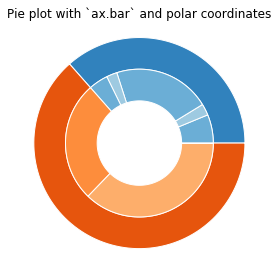

In [51]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw=dict(polar=True))

size = 0.3
vals = np.array([[no_caption, no_image, collections, too_few, finsta], [vanilla, nonvanilla, 0, 0, 0]])
labels = np.array([["no caption", "no image", "collection", "too few", "finsta"], ["vanilla", "non-vanilla", 0, 0, 0]])
print(vals)
#normalize vals to 2 pi
valsnorm = vals/np.sum(vals)*2*np.pi
#obtain the ordinates of the bar edges
valsleft = np.cumsum(np.append(0, valsnorm.flatten()[:-1])).reshape(vals.shape)

cmap = plt.get_cmap("tab20c")
outer_colors = cmap(np.arange(2)*4)
inner_colors = cmap(np.array([1, 2, 1, 2, 1, 5, 6, 0, 0]))

ax.bar(x=valsleft[:, 0],
       width=valsnorm.sum(axis=1), bottom=1-size, height=size,
       color=outer_colors, edgecolor='w', linewidth=1, align="edge")

ax.bar(x=valsleft.flatten(),
       width=valsnorm.flatten(), bottom=1-2*size, height=size,
       color=inner_colors, edgecolor='w', linewidth=1, align="edge")

ax.set(title="Pie plot with `ax.bar` and polar coordinates")
ax.set_axis_off()
plt.show()

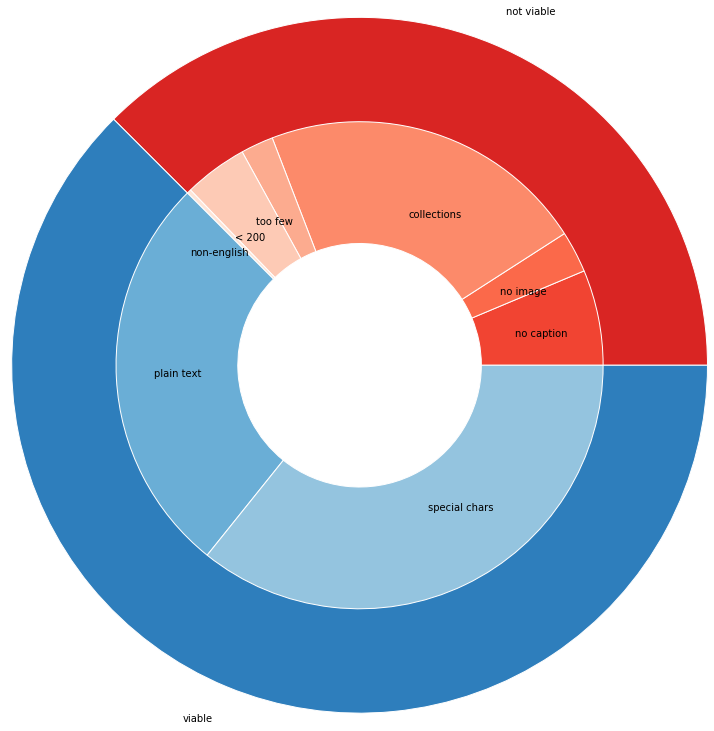

In [157]:
import matplotlib.pyplot as plt
 
# Make data: I have 3 groups and 7 subgroups
group_names=['not viable', 'viable']
group_size=[throwing_out, running_total]
subgroup_names=["no caption", "no image", "collections", "too few", "< 200", "non-english", "plain text", "special chars"]
subgroup_size = [no_caption, no_image, collections, too_few, finsta, non_english, vanilla, nonvanilla]
 
# Create colors
a, b = [plt.cm.Reds, plt.cm.Blues]
 
# First Ring (outside)
fig, ax = plt.subplots()
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=4, labels=group_names, colors=[a(0.7), b(0.7)] )
plt.setp( mypie, width=1.4, edgecolor='white')
 
# Second Ring (Inside)
mypie2, _ = ax.pie(subgroup_size, radius=4-1.2, labels=subgroup_names, labeldistance=0.65, colors=[a(0.6), a(0.5), a(0.4), a(0.3), a(0.2), a(0.1), b(0.5), b(0.4)])
plt.setp( mypie2, width=1.4, edgecolor='white')
plt.margins(0,0)
 
# show it
plt.show()
fig.savefig('piechart_distribution.png', bbox_inches='tight', pad_inches=1)

In [68]:

print(is_in_english('“办理美国加州州立大学圣贝。纳迪诺分校高仿成绩。单Q/V2166384296加州州立。大学圣贝纳迪诺分校学历学位认证'))
print(is_in_english(' MUUCHISIMAAS FELICIDADEES A UNA PERRA EN CONDICIONES: @noelious_garcia , porfin tus queridos 18 , vamos a darles usoo a esa mayoria de edaad eh😏 Ademas aprovecho a desearle mucha suerte a @andrea_cuesta21 en su nueva etapa por aquellas tierras, que se que la va a ir mas que genial, y que en anda el trio la esta liando de nuevo🙌🙌🙌🎉🎊🎉 #errtrio #volvemosalasandadasennada #londresnosespera #madridtambien 😂😂😂😂😂'))
print(is_in_english('feliz navidad bitches'))
print(is_in_english('😂'))
print(is_in_english('“Two things are infinite: the universe and human stupidity; and I\'m not sure about the universe.”'))


['办理美国加州州立大学圣贝', '纳迪诺分校高仿成绩', '单Q', '加州州立', '大学圣贝纳迪诺分校学历学位认证']
False
['MUUCHISIMAAS', 'FELICIDADEES', 'PERRA', 'CONDICIONES', 'noelious', 'garcia', 'porfin', 'tus', 'queridos', 'vamos', 'darles', 'usoo', 'esa', 'mayoria', 'de', 'edaad', 'Ademas', 'aprovecho', 'desearle', 'mucha', 'suerte', 'andrea', 'cuesta', 'su', 'nueva', 'etapa', 'por', 'aquellas', 'tierras', 'que', 'se', 'que', 'va', 'ir', 'que', 'que', 'anda', 'esta', 'liando', 'de', 'nuevo', 'errtrio', 'volvemosalasandadasennada', 'londresnosespera', 'madridtambien']
False
['feliz', 'navidad']
True
[]
True
[]
True


In [93]:
import csv
csv_file = 'erikaaanakagawa_followers.csv'
txt_file = 'erikaaanakagawa_followers.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        i = 0
        for row in csv.reader(my_input_file):
            if i == 0:
                my_output_file.write(''.join(row)[1::] + '\n')
            else:
                my_output_file.write(''.join(row) + '\n')
            i += 1
    my_output_file.close()

In [158]:
import networkx as nx
from netwulf import visualize

nodes = [[], [], []]
core_nodes = ['sejaldua99', 'camillebowman', 'erikaaanakagawa']
for i, root in enumerate(dirs):
    for fn in os.listdir("profiles/profiles_" + root + "/"):
        if fn.endswith(".json"):
            nodes[i].append(fn[0:fn.find('2019')-1])

# Create graph and add characters
G = nx.Graph()
for i in range(len(nodes)):
    G.add_nodes_from(nodes[i])
    for c in nodes[i]:
        G.add_edge(c, core_nodes[i])

print(len(G.edges))
visualize(G)

2600


(None, None)